In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
interval = '1m'
# USDT base
#pairs = ['BTCUSDT', 'ETHUSDT','ADAUSDT','CHZUSDT','ENJUSDT','LINKUSDT','FILUSDT','XRPUSDT', 'DOTUSDT']
# BTC base
#pairs = ['ETHBTC','ADABTC','CHZBTC','ENJBTC','LINKBTC','FILBTC','XRPBTC', 'DOTBTC']
#recomendations from Fausto Botelho in 29/07/2021 (https://www.youtube.com/channel/UCFzEG7N47dktszRxdfOHJdA)
pairs = ['BATBTC', 
    'BNBBTC', 
    'CHZBTC', 
    'ETHBTC', 
    'KNCBTC', 
    'MATICBTC', 
    'XEMBTC', 
    'ONTBTC', 
    'CAKEBTC', 
    'RENBTC', 
    'XRPBTC', 
    'SOLBTC', 
    'STEEMBTC', 
    'SUSHIBTC', 
    'TRXBTC', 
    'UNIBTC']

# date to start/end analysis
dt_start_analysis = '2021-6-1'
# Use '' for analysis until now
dt_end_analysis = ''

In [24]:
from trade_utils import initialize_ohlc_df
from binance_utils import update_historical_data

crypto_pairs_dict = {}

for pair in pairs:
    try:
        df = pd.read_csv('data/' + pair + '-' + interval + '-binance-all.csv')
        df['OpenTime'] = pd.to_datetime(df['OpenTime'])
        df.set_index('OpenTime', inplace=True)
    except FileNotFoundError:
        df = initialize_ohlc_df()
    
    df = update_historical_data(df, pair, interval)

    filename = 'data/' + pair + '-' + interval + '-binance-all.csv'
    df.to_csv(filename)

    if dt_end_analysis == '':
        crypto_pairs_dict[pair] = df[dt_start_analysis:]
    else:
        crypto_pairs_dict[pair] = df[dt_start_analysis:dt_end_analysis]

In [25]:
# Example
pair = 'ETHBTC'

crypto_pairs_dict[pair].tail()

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
OpenTime,,,,,
2021-07-30 16:05:00,0.060111,0.060135,0.060090,0.060116,28.774
2021-07-30 16:06:00,0.060116,0.060126,0.060096,0.060116,22.968
2021-07-30 16:07:00,0.060107,0.060142,0.060107,0.060142,38.456
2021-07-30 16:08:00,0.060143,0.060160,0.060138,0.060160,15.365
2021-07-30 16:09:00,0.060161,0.060236,0.060161,0.060236,56.410


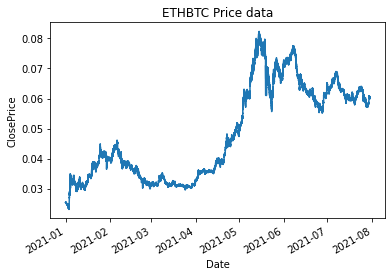

In [26]:
crypto_pairs_dict[pair]['ClosePrice'].plot()
plt.xlabel('Date')
plt.ylabel('ClosePrice')
plt.title(pair + " Price data")
plt.show()

In [27]:
daily_returns = crypto_pairs_dict[pair]['ClosePrice'].pct_change()
monthly_returns = crypto_pairs_dict[pair]['ClosePrice'].resample('M').ffill().pct_change()

In [28]:
daily_returns.head()

OpenTime
2021-01-01 00:00:00         NaN
2021-01-01 00:01:00    0.000629
2021-01-01 00:02:00   -0.000432
2021-01-01 00:03:00   -0.000432
2021-01-01 00:04:00   -0.000275
Name: ClosePrice, dtype: float64

In [29]:
monthly_returns.head()

OpenTime
2021-01-31         NaN
2021-02-28   -0.214816
2021-03-31   -0.007942
2021-04-30    0.642768
2021-05-31    0.296492
Freq: M, Name: ClosePrice, dtype: float64

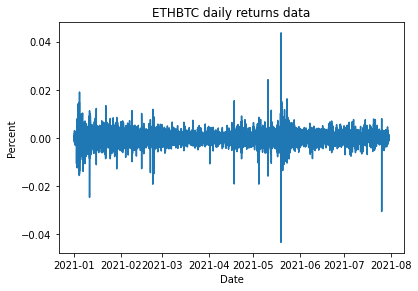

In [30]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(daily_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title(pair + " daily returns data")
plt.show()

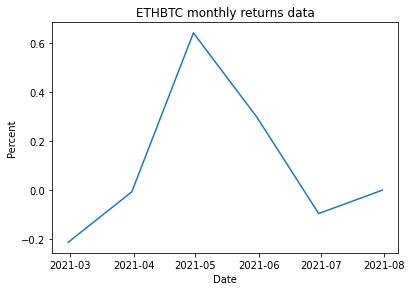

In [31]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.plot(monthly_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Percent")
ax1.set_title(pair + " monthly returns data")
plt.show()

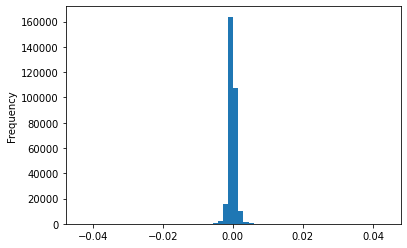

In [32]:
fig = plt.figure()
#ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
daily_returns.plot.hist(bins = 60)
ax1.set_xlabel("Daily returns %")
ax1.set_ylabel("Percent")
ax1.set_title(pair + " daily returns data")
plt.show()

In [33]:
cum_returns = (daily_returns + 1).cumprod()

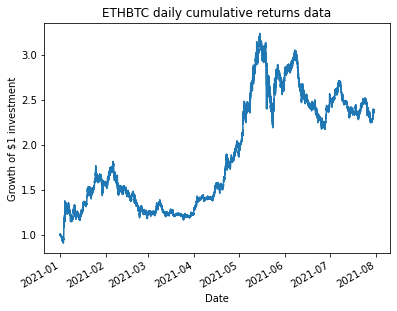

In [34]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
cum_returns.plot()
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title(pair + " daily cumulative returns data")
plt.show()

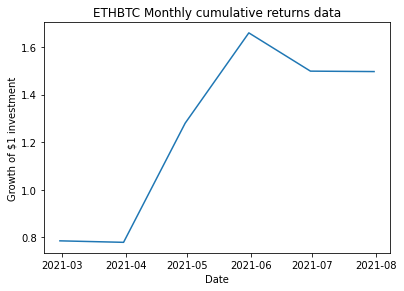

In [35]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
cum_returns = (monthly_returns + 1).cumprod()
ax1.plot(cum_returns)
ax1.set_xlabel("Date")
ax1.set_ylabel("Growth of $1 investment")
ax1.set_title(pair + " Monthly cumulative returns data")
plt.show()

<Figure size 432x288 with 0 Axes>

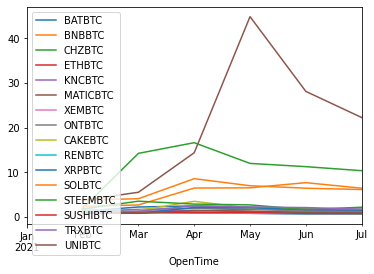

In [36]:
multpl_crypto_daily_returns = pd.DataFrame()
multpl_crypto_monthly_returns = pd.DataFrame()

for pair in pairs:
    multpl_crypto_daily_returns[pair] = crypto_pairs_dict[pair]['ClosePrice'].pct_change()
    multpl_crypto_monthly_returns[pair] = crypto_pairs_dict[pair]['ClosePrice'].resample('M').ffill().pct_change()

fig = plt.figure()
(multpl_crypto_monthly_returns + 1).cumprod().plot()
plt.show()

In [37]:
print(multpl_crypto_monthly_returns.mean())

BATBTC      0.123499
BNBBTC      0.600968
CHZBTC      1.217279
ETHBTC      0.103063
KNCBTC      0.007828
MATICBTC    1.055278
XEMBTC     -0.002202
ONTBTC      0.049950
CAKEBTC     0.249694
RENBTC     -0.065158
XRPBTC      0.195459
SOLBTC      0.486462
STEEMBTC    0.235707
SUSHIBTC   -0.046525
TRXBTC      0.143318
UNIBTC      0.009950
dtype: float64


In [38]:
print(multpl_crypto_monthly_returns.std())

BATBTC      0.356695
BNBBTC      1.141748
CHZBTC      2.721487
ETHBTC      0.313984
KNCBTC      0.208721
MATICBTC    1.268744
XEMBTC      0.459430
ONTBTC      0.245175
CAKEBTC     0.731858
RENBTC      0.212333
XRPBTC      0.760255
SOLBTC      0.703914
STEEMBTC    0.551419
SUSHIBTC    0.190214
TRXBTC      0.434641
UNIBTC      0.292781
dtype: float64


In [39]:
print(multpl_crypto_monthly_returns.corr())

            BATBTC    BNBBTC    CHZBTC    ETHBTC    KNCBTC  MATICBTC  \
BATBTC    1.000000  0.171480  0.956246 -0.129670  0.763424  0.079613   
BNBBTC    0.171480  1.000000 -0.083801 -0.158473 -0.001646  0.683847   
CHZBTC    0.956246 -0.083801  1.000000 -0.223610  0.731058 -0.141807   
ETHBTC   -0.129670 -0.158473 -0.223610  1.000000  0.239533  0.240572   
KNCBTC    0.763424 -0.001646  0.731058  0.239533  1.000000 -0.233951   
MATICBTC  0.079613  0.683847 -0.141807  0.240572 -0.233951  1.000000   
XEMBTC   -0.187311  0.839301 -0.393893 -0.309802 -0.434498  0.542408   
ONTBTC    0.909932  0.319901  0.780681  0.070161  0.642146  0.306447   
CAKEBTC   0.365858  0.969646  0.167445  0.670386  0.748351  0.228636   
RENBTC   -0.022246  0.883681 -0.212031 -0.478563 -0.324588  0.506815   
XRPBTC    0.038164  0.129463 -0.120520  0.888480  0.495182  0.191177   
SOLBTC    0.129040  0.853579 -0.137466  0.303325  0.259393  0.631931   
STEEMBTC  0.815575  0.320732  0.758198 -0.474656  0.324806  0.16

In [40]:
print(multpl_crypto_monthly_returns.cov())

            BATBTC    BNBBTC    CHZBTC    ETHBTC    KNCBTC  MATICBTC  \
BATBTC    0.127231  0.069836  0.928267 -0.014523  0.056837  0.036029   
BNBBTC    0.069836  1.303588 -0.260392 -0.056811 -0.000392  0.990611   
CHZBTC    0.928267 -0.260392  7.406491 -0.191076  0.415263 -0.489641   
ETHBTC   -0.014523 -0.056811 -0.191076  0.098586  0.015698  0.095836   
KNCBTC    0.056837 -0.000392  0.415263  0.015698  0.043564 -0.061953   
MATICBTC  0.036029  0.990611 -0.489641  0.095836 -0.061953  1.609712   
XEMBTC   -0.030696  0.440259 -0.492498 -0.044690 -0.041665  0.316169   
ONTBTC    0.079576  0.089549  0.520901  0.005401  0.032861  0.095325   
CAKEBTC   0.106059  0.379531  0.372018  0.149556  0.123445  0.185396   
RENBTC   -0.001685  0.214231 -0.122524 -0.031905 -0.014385  0.136534   
XRPBTC    0.010349  0.112376 -0.249358  0.212087  0.078576  0.184404   
SOLBTC    0.032400  0.686015 -0.263343  0.067040  0.038110  0.564369   
STEEMBTC  0.160414  0.201927  1.137813 -0.082180  0.037383  0.11